In [32]:
%pip install tensorflow keras 

Note: you may need to restart the kernel to use updated packages.


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import tensorflow as tf
import random

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's random module
random.seed(42)


Only run the next cell if the data has not been split into training and validation

In [34]:
import os
import shutil
import random

# Set random seed
random.seed(42)

# Define paths
data_dir = 'data/'
train_dir = 'train/'
test_dir = 'test/'

# Clear train and test directories
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of image filenames in each class folder
malignant_images = os.listdir(os.path.join(data_dir, 'malignant'))
normal_images = os.listdir(os.path.join(data_dir, 'normal'))

# Shuffle the filenames
random.shuffle(malignant_images)
random.shuffle(normal_images)

# Define the number of images for training and testing
train_count = 200
test_count = 50

# Split images into training and testing sets
malignant_train_images = malignant_images[:train_count]
malignant_test_images = malignant_images[train_count:train_count+test_count]

normal_train_images = normal_images[:train_count]
normal_test_images = normal_images[train_count:train_count+test_count]

# Copy images to train and test folders
for img in malignant_train_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_train = os.path.join(train_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in malignant_test_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_test = os.path.join(test_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

for img in normal_train_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_train = os.path.join(train_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in normal_test_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_test = os.path.join(test_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

print("Data copied successfully.")


Data copied successfully.


Setting up target size 

In [36]:

# Define directories
train_dir = 'train/'
test_dir = 'test/'

# Count number of files in train directory
train_malignant_count = len(os.listdir(os.path.join(train_dir, 'malignant')))
train_normal_count = len(os.listdir(os.path.join(train_dir, 'normal')))

# Count number of files in test directory
test_malignant_count = len(os.listdir(os.path.join(test_dir, 'malignant')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'normal')))

# Print counts
print("Train directory:")
print(f"Malignant: {train_malignant_count} images")
print(f"Normal: {train_normal_count} images")

print("\nTest directory:")
print(f"Malignant: {test_malignant_count} images")
print(f"Normal: {test_normal_count} images")


Train directory:
Malignant: 200 images
Normal: 200 images

Test directory:
Malignant: 50 images
Normal: 50 images


In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define image dimensions and other parameters
img_height = 128
img_width = 128
epochs = 10

# Create ImageDataGenerators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=400,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=100,
    class_mode='binary')




Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [38]:
x_test, y_test = next(test_generator)

print(x_test.shape, y_test.shape)
num_samples = x_test.shape[0]
print("Number of samples in x_test:", num_samples)


(100, 128, 128, 3) (100,)
Number of samples in x_test: 100


In [39]:
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, optimizer='adam', epochs=10, batch_size=32, verbose=1):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.compile(optimizer=self.optimizer,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype('int32')

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


In [40]:

from sklearn.model_selection import GridSearchCV

# Define CNN model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

# Wrap Keras model in a scikit-learn compatible classifier
model = CustomKerasClassifier(build_fn=create_model, verbose=0)




In [41]:

# Define hyperparameters for grid search
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'optimizer': ['adam', 'sgd']
}

# Load the images
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

# Grid search
grid_search = GridSearchCV(estimator=CustomKerasClassifier(create_model), param_grid=param_grid, cv=5, return_train_score=True)
grid_search.fit(train_images, train_labels)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
test_accuracy = best_model.score(test_images, test_labels)
print("Test Accuracy:", test_accuracy)


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6019 - loss: 0.6844
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.7251 - loss: 0.5158
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.7859 - loss: 0.4082
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.7779 - loss: 0.3401
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.8421 - loss: 0.2749
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9205 - loss: 0.2088
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9091 - loss: 0.1920
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8189 - loss: 0.3315
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.9269 - loss: 0.1957
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9620 - loss: 0.1205
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.6124 - loss: 0.6698
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.7509 - loss: 0.4806
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.8149 - loss: 0.3710
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.8888 - loss: 0.3103
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9081 - loss: 0.2319
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.8539 - loss: 0.2818
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9204 - loss: 0.1860
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.9434 - loss: 0.1486
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.9634 - loss: 0.1072
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.9491 - loss: 0.1098
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.5369 - loss: 0.8135
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.7609 - loss: 0.5299
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.7769 - loss: 0.4867
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.7882 - loss: 0.4047
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.7715 - loss: 0.3521
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.8638 - loss: 0.3050
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.8356 - loss: 0.2905
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.8800 - loss: 0.2456
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.8880 - loss: 0.2684
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.9226 - loss: 0.1960
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.5725 - loss: 0.7340
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.7384 - loss: 0.5447
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.7815 - loss: 0.4858
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.8599 - loss: 0.3703
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.8402 - loss: 0.3114
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.9220 - loss: 0.1893
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.8840 - loss: 0.1990
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.9607 - loss: 0.1348
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.9679 - loss: 0.0954
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.9536 - loss: 0.1015
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.5168 - loss: 0.6729
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.7814 - loss: 0.5246
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.8116 - loss: 0.4965
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.8101 - loss: 0.4321
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.8491 - loss: 0.2961
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.8665 - loss: 0.2536
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.9096 - loss: 0.1682
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.9416 - loss: 0.1133
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.9491 - loss: 0.1500
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9590 - loss: 0.1302
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.5667 - loss: 0.6892
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.6877 - loss: 0.6723
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.6844 - loss: 0.6594
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.6732 - loss: 0.6458
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.6659 - loss: 0.6330
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.6570 - loss: 0.6209
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.6646 - loss: 0.6094
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.6739 - loss: 0.5985
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.6622 - loss: 0.5884
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.6818 - loss: 0.5788
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.5216 - loss: 0.6864
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.7043 - loss: 0.6697
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.7043 - loss: 0.6582
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7043 - loss: 0.6473
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.7043 - loss: 0.6354
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.7025 - loss: 0.6224
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6941 - loss: 0.6083
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.6756 - loss: 0.5948
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.6657 - loss: 0.5822
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.6804 - loss: 0.5709
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.4754 - loss: 0.6925
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.6974 - loss: 0.6791
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.6974 - loss: 0.6697
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.6974 - loss: 0.6615
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.6905 - loss: 0.6534
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.6918 - loss: 0.6449
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.6814 - loss: 0.6358
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6715 - loss: 0.6263
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.6619 - loss: 0.6167
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.6562 - loss: 0.6075
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.5273 - loss: 0.6889
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.7368 - loss: 0.6702
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.7368 - loss: 0.6584
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.7359 - loss: 0.6475
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.7325 - loss: 0.6367
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.7197 - loss: 0.6261
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.7224 - loss: 0.6154
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7060 - loss: 0.6056
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6849 - loss: 0.5962
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.7018 - loss: 0.5873
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.5969 - loss: 0.6851
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.7338 - loss: 0.6613
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.7359 - loss: 0.6450
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.7256 - loss: 0.6300
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.7204 - loss: 0.6162
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.6876 - loss: 0.6034
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.7079 - loss: 0.5917
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.7472 - loss: 0.5808
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.7263 - loss: 0.5706
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.7228 - loss: 0.5607
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Epoch 1/20


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.5187 - loss: 0.6906
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7300 - loss: 0.5212
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.7765 - loss: 0.4753
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.8122 - loss: 0.3973
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.8514 - loss: 0.2827
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.8806 - loss: 0.2470
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.9246 - loss: 0.1702
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.9646 - loss: 0.1684
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.9340 - loss: 0.1234
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.9709 - loss: 0.0885
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.9853 - loss: 0.0460
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.5745 - loss: 0.6551
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.7392 - loss: 0.4924
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.8115 - loss: 0.3864
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.7566 - loss: 0.3787
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9033 - loss: 0.3057
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.9041 - loss: 0.2404
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.8705 - loss: 0.2198
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9357 - loss: 0.1379
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.9430 - loss: 0.1208
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9656 - loss: 0.0772
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9798 - loss: 0.0457
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.4578 - loss: 0.6826
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7580 - loss: 0.5242
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.7699 - loss: 0.4826
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.7817 - loss: 0.4000
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.8194 - loss: 0.3606
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.7769 - loss: 0.3799
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.8155 - loss: 0.3309
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.8677 - loss: 0.2720
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.8700 - loss: 0.2706
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9047 - loss: 0.2083
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.9332 - loss: 0.1665
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.4869 - loss: 0.7122
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.6686 - loss: 0.5380
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7616 - loss: 0.5143
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.8264 - loss: 0.4446
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.8430 - loss: 0.3311
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.8774 - loss: 0.2865
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.9258 - loss: 0.2003
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.9271 - loss: 0.1731
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.9337 - loss: 0.1382
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.9765 - loss: 0.1045
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - accuracy: 0.9846 - loss: 0.0894
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.4925 - loss: 0.7010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.7382 - loss: 0.5242
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.7788 - loss: 0.4759
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.7778 - loss: 0.3766
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.8176 - loss: 0.3147
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.8475 - loss: 0.2845
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.8729 - loss: 0.2408
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.8830 - loss: 0.2444
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9199 - loss: 0.1988
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.9256 - loss: 0.1625
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.9447 - loss: 0.1304
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.4673 - loss: 0.7018
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6766 - loss: 0.6838
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.6892 - loss: 0.6737
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.6892 - loss: 0.6652
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 812ms/step - accuracy: 0.6919 - loss: 0.6565
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.6885 - loss: 0.6478
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.6783 - loss: 0.6384
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.6750 - loss: 0.6284
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.6698 - loss: 0.6182
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.6545 - loss: 0.6077
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.6409 - loss: 0.5975
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.5814 - loss: 0.6827
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.7043 - loss: 0.6646
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.7009 - loss: 0.6492
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.6897 - loss: 0.6332
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.6769 - loss: 0.6179
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.6605 - loss: 0.6037
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 935ms/step - accuracy: 0.6747 - loss: 0.5901
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.6792 - loss: 0.5781
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6956 - loss: 0.5682
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.6998 - loss: 0.5592
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7033 - loss: 0.5497
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.5236 - loss: 0.6903
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.7126 - loss: 0.6683
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7126 - loss: 0.6525
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 708ms/step - accuracy: 0.7172 - loss: 0.6373
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.7050 - loss: 0.6223
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.7051 - loss: 0.6079
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7240 - loss: 0.5950
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7415 - loss: 0.5833
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7438 - loss: 0.5724
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 678ms/step - accuracy: 0.7770 - loss: 0.5625
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.7842 - loss: 0.5534
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5034 - loss: 0.6913
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.7368 - loss: 0.6741
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.7368 - loss: 0.6633
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.7368 - loss: 0.6529
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.7368 - loss: 0.6420
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 824ms/step - accuracy: 0.7334 - loss: 0.6305
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.7317 - loss: 0.6187
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7181 - loss: 0.6074
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7019 - loss: 0.5967
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.7032 - loss: 0.5864
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.7349 - loss: 0.5764
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 914ms/step - accuracy: 

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.4933 - loss: 0.6939
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7350 - loss: 0.6812
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7350 - loss: 0.6719
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7350 - loss: 0.6637
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.7350 - loss: 0.6560
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 502ms/step - accuracy: 0.7350 - loss: 0.6484
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.7342 - loss: 0.6406
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7161 - loss: 0.6325
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.7143 - loss: 0.6241
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.6968 - loss: 0.6156
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7042 - loss: 0.6069
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 845ms/step - accurac

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.4868 - loss: 0.6881
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.6134 - loss: 0.5884
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.7212 - loss: 0.5178
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.7807 - loss: 0.4802
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.7829 - loss: 0.4228
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.8349 - loss: 0.3441
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8938 - loss: 0.2761 
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 820ms/step - accuracy: 0.8847 - loss: 0.2366
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - accuracy: 0.9235 - loss: 0.1890
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.8819 - loss: 0.1993
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 650ms/step - accuracy: 0.4885 - loss: 0.6769
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.6269 - loss: 0.5764
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.7232 - loss: 0.5104
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.7658 - loss: 0.4772
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.7763 - loss: 0.4309
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7868 - loss: 0.3762  
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 748ms/step - accuracy: 0.7961 - loss: 0.3260
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - accuracy: 0.8050 - loss: 0.3251
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9272 - loss: 0.2458  
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8970 - loss: 0.2261  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4289 - loss: 0.8009
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.5711 - loss: 0.5904
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - accuracy: 0.7551 - loss: 0.5305
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - accuracy: 0.7885 - loss: 0.5109
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8141 - loss: 0.4961  
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 941ms/step - accuracy: 0.8429 - loss: 0.4683
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 853ms/step - accuracy: 0.8569 - loss: 0.4372
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 889ms/step - accuracy: 0.8703 - loss: 0.3902
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 712ms/step - accuracy: 0.8974 - loss: 0.3359
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - accuracy: 0.9001 - loss: 0.3073
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 911ms/step - accuracy: 0.4541 - loss: 0.7735
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 719ms/step - accuracy: 0.5683 - loss: 0.5897
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7416 - loss: 0.5327  
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 995ms/step - accuracy: 0.7956 - loss: 0.5189
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 700ms/step - accuracy: 0.7901 - loss: 0.5108
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.8309 - loss: 0.5000
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.8135 - loss: 0.4936
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 954ms/step - accuracy: 0.8441 - loss: 0.4736
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 652ms/step - accuracy: 0.8752 - loss: 0.4397
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step - accuracy: 0.8968 - loss: 0.3983
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4094 - loss: 0.7084
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.6102 - loss: 0.5830
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.7499 - loss: 0.5237
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7796 - loss: 0.5116
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 840ms/step - accuracy: 0.7804 - loss: 0.4993
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7812 - loss: 0.4908 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.7812 - loss: 0.4770
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.7862 - loss: 0.4404
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.8474 - loss: 0.3773
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.7835 - loss: 0.3477
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6099 - loss: 0.6862
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step - accuracy: 0.7042 - loss: 0.6797
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.7042 - loss: 0.6746
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.7042 - loss: 0.6698
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - accuracy: 0.7042 - loss: 0.6650
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.7042 - loss: 0.6602
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step - accuracy: 0.7042 - loss: 0.6552
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.7003 - loss: 0.6500
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6942 - loss: 0.6448  
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 890ms/step - accuracy: 0.6942 - loss: 0.6394
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.4639 - loss: 0.6922
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.6982 - loss: 0.6839
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.7072 - loss: 0.6774
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.7072 - loss: 0.6718
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.7072 - loss: 0.6668
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7072 - loss: 0.6618 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 762ms/step - accuracy: 0.7072 - loss: 0.6568
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - accuracy: 0.7072 - loss: 0.6516
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.7072 - loss: 0.6462
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step - accuracy: 0.7072 - loss: 0.6408
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4625 - loss: 0.6929
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.6184 - loss: 0.6845
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.7100 - loss: 0.6784
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7100 - loss: 0.6730 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.7100 - loss: 0.6677
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.7100 - loss: 0.6623
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.7100 - loss: 0.6567
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.7100 - loss: 0.6509
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7074 - loss: 0.6449 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 875ms/step - accuracy: 0.7066 - loss: 0.6387
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.5365 - loss: 0.6848
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.7400 - loss: 0.6729
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.7400 - loss: 0.6647
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.7400 - loss: 0.6585
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7400 - loss: 0.6528
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 786ms/step - accuracy: 0.7400 - loss: 0.6472
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.7400 - loss: 0.6415
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.7400 - loss: 0.6359
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.7400 - loss: 0.6300
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7375 - loss: 0.6239  
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.3839 - loss: 0.6935
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.7262 - loss: 0.6842
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.7343 - loss: 0.6768
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7369 - loss: 0.6709  
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 955ms/step - accuracy: 0.7369 - loss: 0.6657
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 0.7369 - loss: 0.6608
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - accuracy: 0.7369 - loss: 0.6562
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - accuracy: 0.7369 - loss: 0.6516
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7369 - loss: 0.6469 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 771ms/step - accuracy: 0.7369 - loss: 0.6420
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Epoch 1/20


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - accuracy: 0.5014 - loss: 0.6912
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 0.5583 - loss: 0.5843
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7079 - loss: 0.5336
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 911ms/step - accuracy: 0.8136 - loss: 0.5032
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.7915 - loss: 0.4738
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.7957 - loss: 0.4186
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.8545 - loss: 0.3413
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8604 - loss: 0.2685  
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 998ms/step - accuracy: 0.8597 - loss: 0.2900
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - accuracy: 0.8662 - loss: 0.2445
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.9231 - loss: 0.2284
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.8832 - loss: 0.2342
Epoc

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4817 - loss: 0.6767
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 618ms/step - accuracy: 0.5807 - loss: 0.5762
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - accuracy: 0.6915 - loss: 0.5332
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.7632 - loss: 0.5038
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7720 - loss: 0.4908 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 917ms/step - accuracy: 0.7747 - loss: 0.4676
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 0.7695 - loss: 0.4329
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.8028 - loss: 0.3683
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8454 - loss: 0.3447
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step - accuracy: 0.7436 - loss: 0.4202
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.8782 - loss: 0.3407
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.8509 - loss: 0.31

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 534ms/step - accuracy: 0.4585 - loss: 0.7927
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.5398 - loss: 0.6228
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.7100 - loss: 0.5470
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.7265 - loss: 0.5196
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8190 - loss: 0.5100  
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7421 - loss: 0.4979
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 681ms/step - accuracy: 0.8242 - loss: 0.4804
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.8152 - loss: 0.4572
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.8891 - loss: 0.3699
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.8757 - loss: 0.2900
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9057 - loss: 0.2104
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 942ms/step - accuracy: 0.9338 - loss: 0.1

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 954ms/step - accuracy: 0.4610 - loss: 0.7915
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.5683 - loss: 0.5996
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.7399 - loss: 0.5416
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - accuracy: 0.7821 - loss: 0.5233
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.8087 - loss: 0.5115
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7797 - loss: 0.5025
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.7833 - loss: 0.4889
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 0.8687 - loss: 0.4552
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - accuracy: 0.8143 - loss: 0.4056
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8974 - loss: 0.3099
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9225 - loss: 0.2226
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - accuracy: 0.9163 - loss: 0.1787


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - accuracy: 0.4020 - loss: 0.7104
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.6091 - loss: 0.5728
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.7624 - loss: 0.5148
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7812 - loss: 0.4930
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 944ms/step - accuracy: 0.8176 - loss: 0.4395
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 677ms/step - accuracy: 0.7884 - loss: 0.3852
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/step - accuracy: 0.7881 - loss: 0.3346
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.8894 - loss: 0.2872
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - accuracy: 0.8293 - loss: 0.3052
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8792 - loss: 0.2847  
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8818 - loss: 0.2469
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 956ms/step - accuracy: 0.8908 - loss: 0.2076
Epoch 1

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 803ms/step - accuracy: 0.5761 - loss: 0.6834
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.7016 - loss: 0.6754
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.7016 - loss: 0.6691
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.7016 - loss: 0.6633
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.7016 - loss: 0.6574
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7016 - loss: 0.6510
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - accuracy: 0.7016 - loss: 0.6443
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.6935 - loss: 0.6375
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.6901 - loss: 0.6305
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6826 - loss: 0.6232
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 587ms/step - accuracy: 0.6874 - loss: 0.6162
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - accuracy: 0.6916 - loss: 0

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 764ms/step - accuracy: 0.4859 - loss: 0.6909
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 940ms/step - accuracy: 0.6926 - loss: 0.6836
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.7008 - loss: 0.6775
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.7046 - loss: 0.6721
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.7046 - loss: 0.6673
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.7046 - loss: 0.6627
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7046 - loss: 0.6581  
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 789ms/step - accuracy: 0.7046 - loss: 0.6536
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.7046 - loss: 0.6489
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.7046 - loss: 0.6440
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.7046 - loss: 0.6390
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 784ms/step - accuracy: 0.7046 - los

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 446ms/step - accuracy: 0.5477 - loss: 0.6842
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.6989 - loss: 0.6713
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.7053 - loss: 0.6610
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.7053 - loss: 0.6526
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - accuracy: 0.6963 - loss: 0.6442
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.6980 - loss: 0.6363
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.7044 - loss: 0.6285
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 828ms/step - accuracy: 0.6972 - loss: 0.6209
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.6843 - loss: 0.6132
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.6761 - loss: 0.6059
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.6646 - loss: 0.5988
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step - accuracy: 0.6747 - lo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.3175 - loss: 0.7004
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.7229 - loss: 0.6832
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7400 - loss: 0.6745  
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.7400 - loss: 0.6679
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 484ms/step - accuracy: 0.7400 - loss: 0.6620
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7400 - loss: 0.6565 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.7400 - loss: 0.6511
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.7400 - loss: 0.6458
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.7375 - loss: 0.6405
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - accuracy: 0.7349 - loss: 0.6352
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - accuracy: 0.7285 - loss: 0.6299
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7259 - loss: 0.6247  
Epoc

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.3637 - loss: 0.6920
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7229 - loss: 0.6722 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.7294 - loss: 0.6609
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.7229 - loss: 0.6516
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.7229 - loss: 0.6429
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.7165 - loss: 0.6345
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.7157 - loss: 0.6262
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7067 - loss: 0.6185 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.6957 - loss: 0.6112
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.7058 - loss: 0.6040
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.6993 - loss: 0.5970
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.7251 - loss: 0.5900
Epoc

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 608ms/step - accuracy: 0.5152 - loss: 0.6645
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.6896 - loss: 0.5515
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.7809 - loss: 0.5033
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 661ms/step - accuracy: 0.8125 - loss: 0.4666
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.8488 - loss: 0.3651
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.8735 - loss: 0.2596
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.9187 - loss: 0.2175
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.8903 - loss: 0.2087
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.9556 - loss: 0.1532
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.9301 - loss: 0.1588
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Test Accuracy: 0.9


In [45]:
# print the results for each combination of hyperparameters
import pandas as pd

results = grid_search.cv_results_

best_rank = min(results['rank_test_score'])
best_index = np.where(results['rank_test_score'] == best_rank)[0][0]

results_dict = {
    'Mean Test Score': results['mean_test_score'],
    'Std Test Score': results['std_test_score'],
    'Mean Train Score': results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank': results['rank_test_score'],
    'Hyperparameters': results['params'],
    'Mean Fit Time': results['mean_fit_time'],
    'Std Fit Time': results['std_fit_time'],
    'Mean Score Time': results['mean_score_time'],
    'Std Score Time': results['std_score_time']
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results_dict)

# Highlight the best model
best_model_index = np.where(results['rank_test_score'] == best_rank)[0][0]
results_df.loc[best_model_index, 'Best Model'] = 'Yes'
results_df.fillna('No', inplace=True)

# Display the DataFrame
results_df



,Mean Test Score,Std Test Score,Mean Train Score,Std Train Score,Rank,Hyperparameters,Mean Fit Time,Std Fit Time,Mean Score Time,Std Score Time,Best Model
0,0.9250,0.022361,0.978125,0.006847,1,"{'batch_size': 32, 'epochs': 10, 'optimizer': ...",27.881815,7.416310,0.601996,0.189303,Yes
1,0.6950,0.051599,0.713750,0.024733,8,"{'batch_size': 32, 'epochs': 10, 'optimizer': ...",21.986400,3.646716,0.506418,0.059104,nan
2,0.8975,0.025495,0.998125,0.002500,2,"{'batch_size': 32, 'epochs': 20, 'optimizer': ...",46.838751,6.379841,0.431154,0.025507,nan
3,0.7700,0.020310,0.774375,0.043499,5,"{'batch_size': 32, 'epochs': 20, 'optimizer': ...",59.440622,6.699297,0.885566,0.537016,nan
4,0.8325,0.046503,0.911875,0.034483,4,"{'batch_size': 64, 'epochs': 10, 'optimizer': ...",43.184351,6.384408,0.703955,0.350035,nan
5,0.7225,0.032016,0.735000,0.010717,6,"{'batch_size': 64, 'epochs': 10, 'optimizer': ...",40.724910,3.094908,1.330929,1.020794,nan
6,0.8925,0.042279,0.973125,0.016370,3,"{'batch_size': 64, 'epochs': 20, 'optimizer': ...",83.725890,5.101851,0.984094,0.632523,nan
7,0.7100,0.071327,0.748750,0.032392,7,"{'batch_size': 64, 'epochs': 20, 'optimizer': ...",69.601214,7.751431,1.033231,1.126367,nan


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'batch_size': 32, 'epochs': 10, 'optimizer': 'adam'}


In [60]:
# Define the model architecture
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create an instance of the model
model = create_model()

model.summary()

# Fit the model
history = model.fit(train_generator, epochs=15, batch_size=128, validation_data=test_generator, verbose=2)  

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_135 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_135               │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_136               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_137               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1/1 - 15s - 15s/step - accuracy: 0.4450 - loss: 0.6879 - val_accuracy: 0.5000 - val_loss: 1.0121
Epoch 2/15
1/1 - 4s - 4s/step - accuracy: 0.5000 - loss: 1.1487 - val_accuracy: 0.5000 - val_loss: 0.6014
Epoch 3/15
1/1 - 5s - 5s/step - accuracy: 0.5000 - loss: 0.6145 - val_accuracy: 0.4700 - val_loss: 0.6350
Epoch 4/15
1/1 - 5s - 5s/step - accuracy: 0.5325 - loss: 0.6304 - val_accuracy: 0.5100 - val_loss: 0.6084
Epoch 5/15
1/1 - 5s - 5s/step - accuracy: 0.5350 - loss: 0.6037 - val_accuracy: 0.5000 - val_loss: 0.5681
Epoch 6/15
1/1 - 5s - 5s/step - accuracy: 0.5000 - loss: 0.5964 - val_accuracy: 0.8000 - val_loss: 0.5381
Epoch 7/15
1/1 - 5s - 5s/step - accuracy: 0.7375 - loss: 0.5470 - val_accuracy: 0.8000 - val_loss: 0.5289
Epoch 8/15
1/1 - 5s - 5s/step - accuracy: 0.7675 - loss: 0.5298 - val_accuracy: 0.8000 - val_loss: 0.5166
Epoch 9/15
1/1 - 10s - 10s/step - accuracy: 0.7625 - loss: 0.5210 - val_accuracy: 0.8000 - val_loss: 0.5131
Epoch 10/15
1/1 - 5s - 5s/step - accuracy:

In [61]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4956388771533966
Test accuracy: 0.8500000238418579


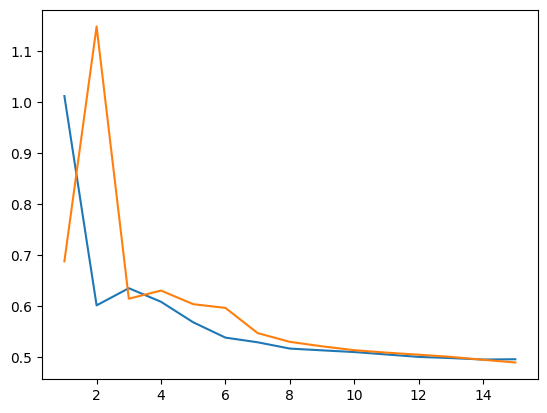

In [62]:

import matplotlib.pyplot as plt
vy = history.history['val_loss']
ty = history.history['loss']
x = list(range(1, len(vy) + 1))  # Adjust x to represent the range of epochs


plt.plot(x, vy)
plt.plot(x, ty)
plt.show()


TypeError: Image data of dtype object cannot be converted to float

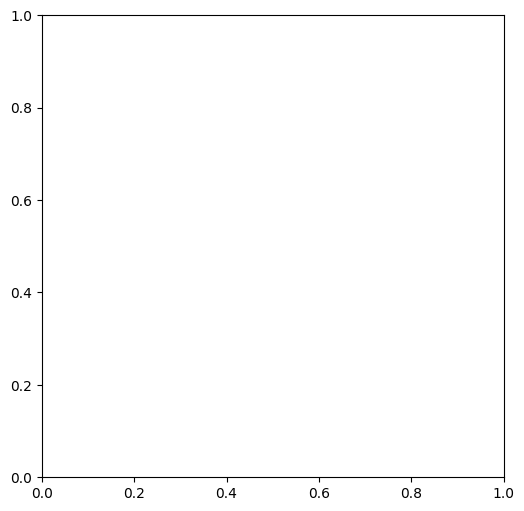

In [63]:

from sklearn.metrics import confusion_matrix as cm
# Define classes
classes = ['Malignant', 'Normal']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [68]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Accuracy:", train_accuracy)

# Make predictions on the train set
train_predictions = model.predict(train_generator)
y_train_pred = np.where(train_predictions > 0.5, 1, 0)  # Thresholding the predictions for binary classification

# Get true labels for the train set
true_train_labels = train_generator.classes

# Print classification report for train data
print("Classification Report (Train Data):")
print(classification_report(true_train_labels, y_train_pred))

# Print accuracy for train data
accuracy_train = accuracy_score(true_train_labels, y_train_pred)
print("Accuracy (Train Data):", accuracy_train)

# Calculate confusion matrix for train data
conf_matrix_train = confusion_matrix(true_train_labels, y_train_pred)

# Calculate true positives, false negatives, true negatives, and false positives for train data
tp_train = conf_matrix_train[1, 1]
fn_train = conf_matrix_train[1, 0]
tn_train = conf_matrix_train[0, 0]
fp_train = conf_matrix_train[0, 1]

# Calculate sensitivity (true positive rate) and specificity (true negative rate) for train data
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)

# Print sensitivity and specificity for train data
print("Sensitivity (Train Data):", sensitivity_train)
print("Specificity (Train Data):", specificity_train)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("\nTest Accuracy:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(test_generator)
y_test_pred = np.where(test_predictions > 0.5, 1, 0)  # Thresholding the predictions for binary classification

# Get true labels for the test set
true_test_labels = test_generator.classes

# Print classification report for test data
print("Classification Report (Test Data):")
print(classification_report(true_test_labels, y_test_pred))

# Print accuracy for test data
accuracy_test = accuracy_score(true_test_labels, y_test_pred)
print("Accuracy (Test Data):", accuracy_test)

# Calculate confusion matrix for test data
conf_matrix_test = confusion_matrix(true_test_labels, y_test_pred)

# Calculate true positives, false negatives, true negatives, and false positives for test data
tp_test = conf_matrix_test[1, 1]
fn_test = conf_matrix_test[1, 0]
tn_test = conf_matrix_test[0, 0]
fp_test = conf_matrix_test[0, 1]

# Calculate sensitivity (true positive rate) and specificity (true negative rate) for test data
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Print sensitivity and specificity for test data
print("Sensitivity (Test Data):", sensitivity_test)
print("Specificity (Test Data):", specificity_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8625 - loss: 0.4865
Train Accuracy: 0.862500011920929
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       200
           1       0.52      0.52      0.52       200

    accuracy                           0.52       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.52      0.52      0.52       400

Accuracy (Train Data): 0.5175
Sensitivity (Train Data): 0.52
Specificity (Train Data): 0.515
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8500 - loss: 0.4956

Test Accuracy: 0.8500000238418579
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.49      0.42      0.45        50
           1       0.49      0.56      0.52        50

    accuracy                           0.49       100
   macr

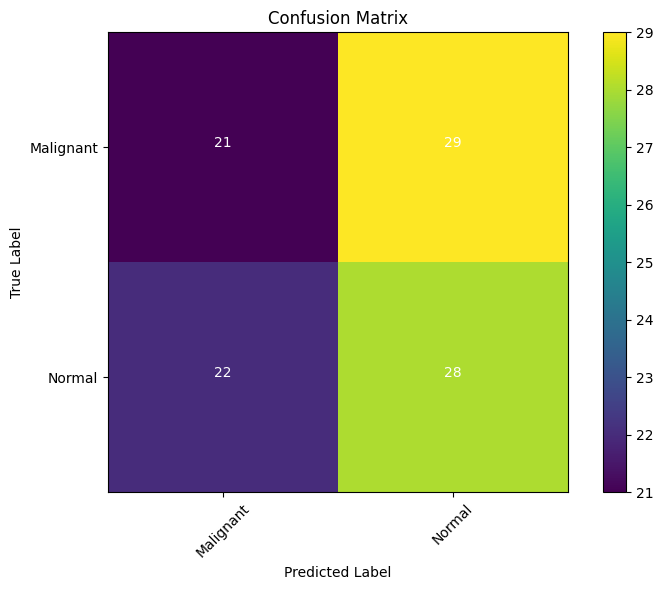

In [72]:
from sklearn.metrics import confusion_matrix as cm

# Define classes
classes = ['Malignant', 'Normal']

# Compute confusion matrix
conf_matrix = cm(true_test_labels, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
